<h1><center>How was last year? Exploring New York Times world news over 1 year time span</center></h1>

## 6.3 Conclusion and further work

Coming back the core of this study I reckon that being able to evaluate how the past year has been is easier to tell than to put in practice - especially from a machine standpoint. Even though there were not great unexpected findings it was interesting to find out how Covid is monopolizing the world newsand many other interesting topics have been partially eclipsed as for example for the climate topic. Sentiment analysis is a great tool but as far as this can be developed there will always be some flaws. Trying to sum up 12 month and making a computer "judge" on the times we are living is somewhat funny and intriguing at the same time. Even if it was not a surprise that the compound result of our analysis has been negative, I always ask myself, with a bit of a smile, whether newspapers ever give positive news in the first place. Of course they do but the negative ones outnumber the positive by far. It might be that we need to take a break from the news and live our life less influenced by them? This might be probably a good way to avoid absorbing less negativity, esplecially considering how depression, panic and anxiety have affected people during this period of lock down. Perhaps being a bit disconnected in a super connected world is not a bad idea.

Given these results, further work could focus more on sentiment analysis insights and the frequency of some words. For example analyze how different topics and sections have different sentiment analysis scores or in which topics certain words are most present. Also would be interesting to see how sentiment analysis evolved in time, analyzing for example what happened in that day in respect to an outlier negative or positive value. It would be interesting to see how the presence of some countries in the keywords chart evolved over time - expecting an evolution of the relevant countries in time due to the spread of the virus.

# Part 2

## 7 - Introduction

We left our first part of the study with a picture of what happened in a 12 months time span basing our judgment on the world news. The study left us with some questions that we are going to try to answer now. First of all we will condense our findings and try to have a finer vision using smaller time frames. Furthermore, since one of the main question marks was if we can use the sentiment analysis as a reliable source of inference of the "status" of the world, we will perform a time series analysis to understand if there's any pattern or seasonability of the bad and good news. We will finally see if we can perform a trend forecasting based on a news topic (eg. Coronavirus) and if this is then reflected in future facts. Also we will perform a correlation analysis between the Coronavirus related topics (which was the main topic) and the compound value of the sentiment analysis.

After we will move our attention on sentiment analysis based on the subsection geography, checking which continent or zone fo the world performed best or worse during these 12 months and which words have been used the most respectively. This could give us some insight of what different countries have been on and what were the main topics for them.

I want to point out how, compared to part one of the study, this time it could be easier that there could be some findings that could lead to some harmful assumptions. This is because we are going to heavily rely our conlusions on the sentiment result. This could end up for example giving a negative outcome for a country compared to others. Given this we need to be aware of sentiment analysis bias. An interesting article about this could be read at this link. Citing the author: [[1]](#references_)

>Automatic systems are beneficial to society but as they improve in predictive performance, comparable to human capabilities, they could perpetuate inappropriate human biases. In the context of sentiment analysis (SA), these biases may come in many forms. For instance, an SA system may consider the messages conveyed by a specific gender or race to be less positive simply because of their race and gender. Therefore, even when it is not clear how biases are manifested, it is the duty and responsibility of the natural language processing (NLP) system developer to address this problem.

At the end of his study he concluded that a strong bias was detected and that race bias was more prevalent than gender bias. Thus, given this inputs we need to carefully consider the results that sentiment analysis will give us.

Let's start importing all the libraries:

In [1]:
#import libraries and modules
import datetime
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from numpy import arange
from ast import literal_eval
from dateutil.parser import parse
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import plotly.express as px
import altair as alt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\massi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("articles_world_2.csv", parse_dates=["date"])

This time we will parse the date column to be able to do some time series analysis:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   headline          6266 non-null   object        
 1   print_headline    3362 non-null   object        
 2   lead_paragraph    6243 non-null   object        
 3   abstract          6262 non-null   object        
 4   document_type     6266 non-null   object        
 5   type_of_material  6266 non-null   object        
 6   keywords          6266 non-null   object        
 7   news_desk         6266 non-null   object        
 8   section_name      6266 non-null   object        
 9   subsection_name   6266 non-null   object        
 10  word_count        6266 non-null   int64         
 11  date              6266 non-null   datetime64[ns]
 12  corpuses          6266 non-null   object        
 13  negative          6266 non-null   float64       
 14  neutral           6266 n

In [4]:
#Set date as index
df.set_index("date", inplace=True)

## 8 Time Series Analysis

Formally, time series is a sequence of observations recorded at regular time intervals. Depending on the frequency of observations, a time series may typically be hourly, daily, weekly, monthly, quarterly and annual.[[2]](#references_)

There are four components of time-series data:
* Data on time trends
* Seasonality in the data
* Non-linear or Structural Breaks
* Noise





### 8.1 Word Cloud and Word Frequency

We start out from the conclusions of part 1 of the study. In particular we will have a look at the monthly results for the Word Cloud graphs and word frequency. 

In [5]:
#creating a dataframe with the various corpuses per each month
df_months = df.pivot_table(index=df.index.month, values="corpuses", aggfunc="sum")

In [6]:
#creating the months list for visualization
month_list = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "Septmeber",
    "October",
    "November",
    "December - 2020"    
    ]

months = list(enumerate(month_list))
    

Calling the text_cleaner function used in part 1 and adding "governament", "country" and "one" to the stopwords list to have a clearer view of predominant topics.

In [7]:
#let's create a text ceaner function to porcess our text
def text_cleaner(text, tokenized=0):
    """
    This function preprocess the text returning a string.
    
    It applies the following steps in this order: 
    punctuation removal, tokenization, removal of stop words, lemmatization.
    
    Args:
        text (str): text to be preprocessed
        tokenized (int, optional): Default = 0. Tokenize text if = 1 

    Returns:
        list: processed tokenized text if tokenized equals 1
        str: processed text
    """
    
    #Tokenize text
    # let's create a pattern to ignore
    pattern = r'''(?x)     # set flag to allow verbose regexps
      (?:[A-Z]\.)+       # abbreviations, e.g. U.S.
    | \w+(?:-\w+)*       # words with optional internal hyphens
    '''
    
    #create tokens excluding the pattern we just created
    tokens = nltk.regexp_tokenize(text, pattern) #tokenized text
            
    #Remove Stopwords - we apply this to normalized words
    stop_words = stopwords.words("english")
    stop_words.extend(["said","say","see", "new","say", "’", "‘","“", "”", "country", ".", "government", "one"]) #added stopwords to list
    filtered_text = [word.rstrip().lstrip() for word in tokens if word.lower() not in stop_words] #rstrip().lstrip() to remove white spaces at the end and beginning fo the word
    
    #Lemmatize text - we want to keep the meaning of the words
    wordnet_lemmatizer  = WordNetLemmatizer()
    lemmatized_text = [wordnet_lemmatizer.lemmatize(word) for word in filtered_text ]
    
    if not tokenized == 1:
        lemmatized_text = " ".join(lemmatized_text)
    
    return lemmatized_text

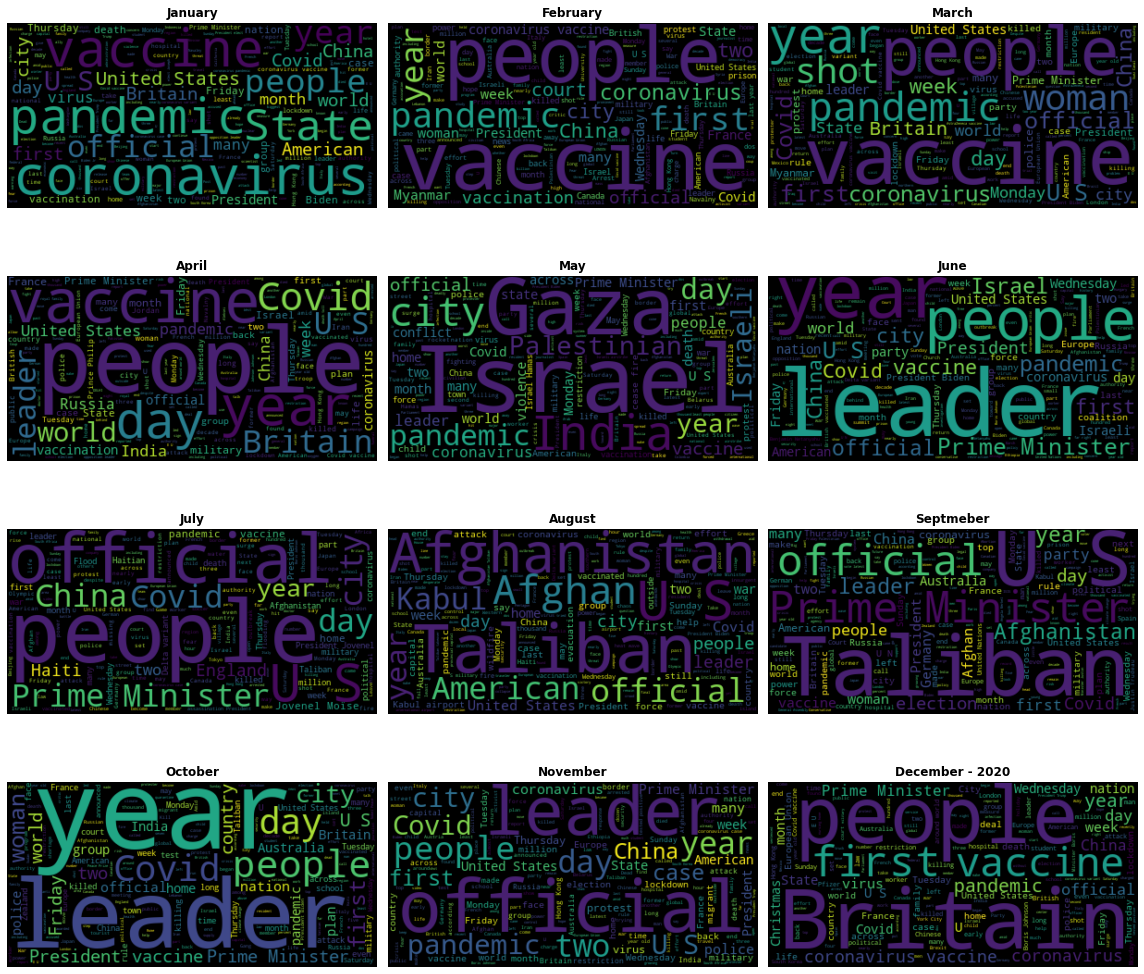

In [8]:
fig, ax = plt.subplots(nrows=4,ncols=3, figsize=(16,16))
ax=ax.ravel()

for month, a in enumerate(ax):
    wordcloud = WordCloud(random_state=42).generate(text_cleaner(df_months.loc[month+1, "corpuses"]))
    a.imshow(wordcloud, interpolation='bilinear')
    a.set_title(months[month][1], weight="bold")
    a.axis('off')
    plt.tight_layout()

It is interesting to note how most of the months are characterized by a supremacy of the presence of Covid related words. But we can see as well that in some of the months there are different prominent topics. In May for example, Gaza and Israel are the main topics - that's because of the raid on Aqsa Mosque. August and September are more focused on Afghanistan - that's a consequence of the Taliban reconquesting the country's capital. In December, the U.K. was the main topic due to the fact that was one of the main countries rolling out vaccines in Europe (please note that December refers to 2020).

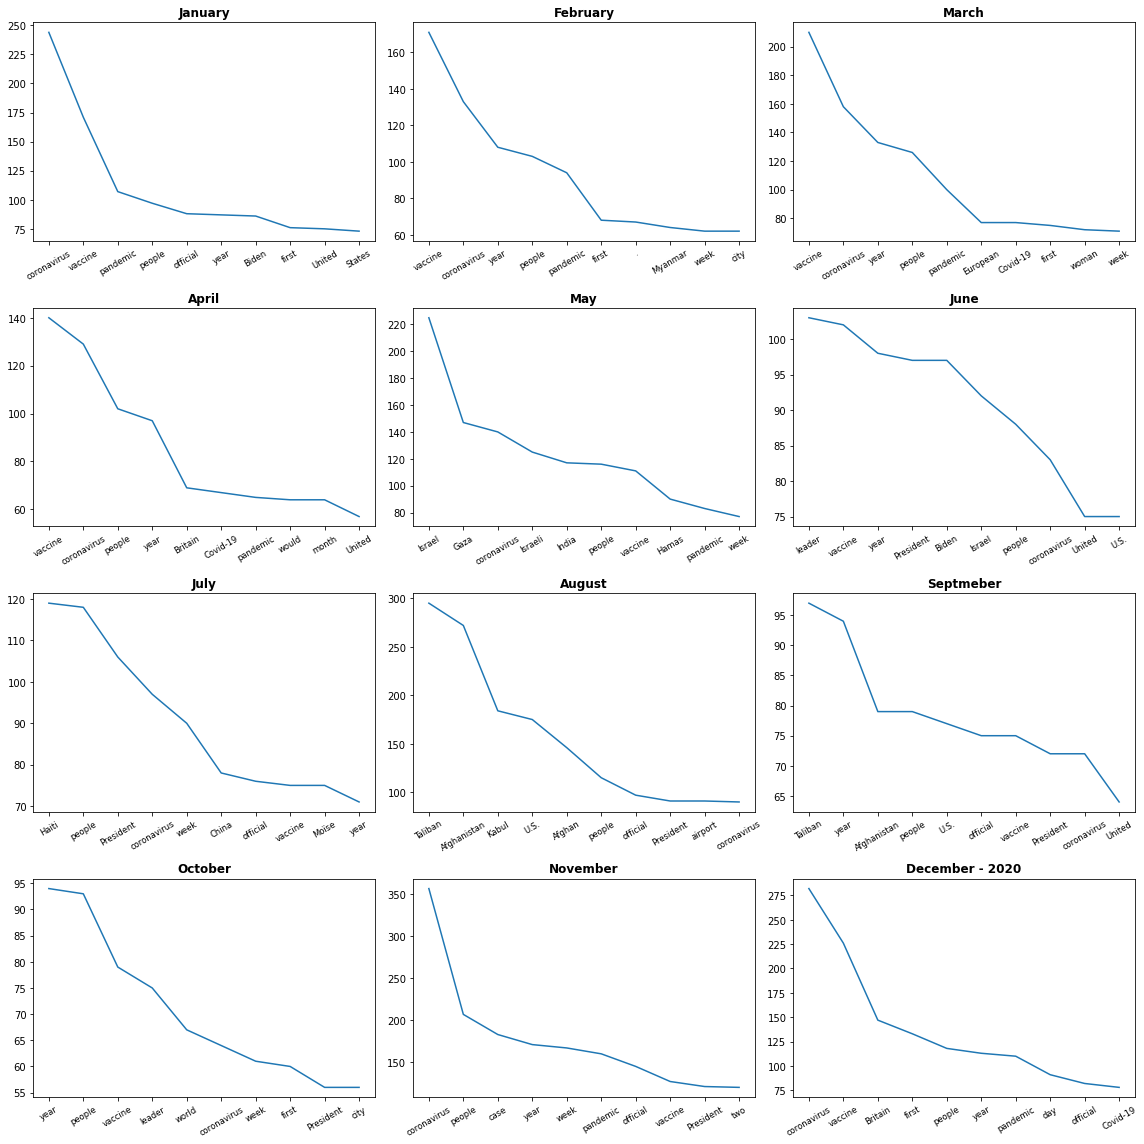

In [9]:
fig, ax = plt.subplots(nrows=4,ncols=3, figsize=(16,16))
ax=ax.ravel() #smoothing the list

for month, a in enumerate(ax):
    f_dist = FreqDist(nltk.tokenize.word_tokenize(text_cleaner(df_months.loc[month+1, "corpuses"])))
    a.plot(*zip(*f_dist.most_common(10))) #tuple upacking for plotting
    a.set_xticklabels(list(zip(*f_dist.most_common(10)))[0], rotation=30, fontsize="small")
    a.set_title(months[month][1], weight="bold")
    plt.tight_layout()


Despite the use of the Word Cloud graphs, we can filter out the Covid related words to try to see what has been the main topic during that time. For example we can see how February has Myanmar as one of the main utilized words -  this is because of the military coup. Also, Haiti is the most used word in July, that's because of the assassination of its President.

### 8.2 Defining the Time Series

As a disclaimer I have never performed a time series analysis before, but since  I wanted to try to make some deductions out of my data I understood that I had to dive deeper into this topic. There isn't any claim of being able to predict good or bad news but we'll try to demonstrate if we can spot any pattern or trend in the sentiment analysis, I want to understand if bad or good news repeat over time in a cyclic manner or if we can spot any anomaly in the data.

First of all we will analyze the kind of data we are dealing with. We will first try to acknowledge if the data is stationary or not because this makes time series analysis easier [[3]](#references_) where a stationary time series is one in which all its statistical characteristics remain unchanged over time [[4]](#references_). Also, knowing time series statistcal properties will help us to disclose if the time series is white noise or random walk alike. More in general we can classify the two as follows:

* White noise:  A time series is white noise when sequence of uncorrelated random variables that are identically distributed. [[5]](#references_)
* Random walk: A random walk is another time series model where the current observation is equal to the previous observation with a noise. [[5]](#references_)

The following conditions must be satisfied for a time series to be classified as white noise:
* The mean value is zero
* Standard deviation is constant — it doesn’t change over time
* The correlation between time series and its lagged version is not significant

While to classify a random walk these are the conditions: [[6]](#references_)
* Non zero mean
* Non constant standard deviation
* Plot looks like a regular distribuition

I am expecting our time series to be in the middle between white noise and random walk. This is because our time series could be very white noise alike but with some random walk characteristics in some cases since the value of the following sentiment day could be influenced by the noise caused by the news of the previous day.

So given these conditions, we will:
* Plot the time series
* Compare mean and standard deviation over time
* Examining autocorrelation plots

In [10]:
sentiment_df = df.groupby(df.index.date)["negative", "neutral", "positive", "compound"].mean()

#### 8.2.1 Stationary Time Series

A quick way to reconize if we are dealing with stationary data is by performing an ADF (Augmented Dicky Fuller) or a KPSS (Kwiatkowski–Phillips–Schmidt–Shin) test. ADF assume the following hipotesys:

* Null hypothesis is that the time series is non-stationary.
* Alternate hypothesis is that the time series is non-stationary.

KPSS exactly the opposite, so onsequently the p value have opposite meaning. That is, if p-value is < signif level (say 0.05), then the series is non-stationary. Whereas in ADF test, it would mean the tested series is stationary. [[7]](#references_)

In [11]:

# ADF Test
result = adfuller(sentiment_df["compound"], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')


# KPSS Test
stats, p, lags, critical_values = kpss(sentiment_df["compound"], 'ct')
print(f'KPSS Test Statistics: {stats}')
print(f'p-value: {p}')

if p<0.05:
      print('Series is not Stationary')
else:
      print('Series is Stationary')

ADF Statistic: -16.6369904066298
p-value: 1.6471703307492156e-29
Series is Stationary
KPSS Test Statistics: 0.13173597340632556
p-value: 0.07641486406236006
Series is Stationary


Given the result for both test we can say that our time series is stationary.

#### 8.2.2 White Noise or Random Walk?

Following our schedule we will now try to understand if we are dealing with white noise or random walk.

##### 8.2.2.1 Plotting the Time Series

In [12]:
plt.rc("figure", figsize=(16, 8))


# interactive time series plot - slide the bottom graph to change the graph granularity
fig = px.line(sentiment_df, x=sentiment_df.index, y='compound', title='Variation of Compound Sentiment in time',
            labels={
                "index": "Date",
                "compound": "Day Mean Sentiment"
            },
            )
fig.update_xaxes(rangeslider_visible=True)
fig.show()

From this graph it looks like standard deviation doesn't change significantly over time, there are occasional spikes but nothing too major. The mean value instead seems negative and not perfectly zero, pheraps this might be because we do not have enough data. Also no strong pattern can be seen from this graph. I would lean towards a white noise alike distribuition already, but let's go ahead with further analysis.

##### 8.2.2.2 Mean and Standar deviation

Let's visualize how the standard deviation and mean change over time. We will visualize it in smaller time chunks for better visualization.

In [13]:
len(sentiment_df["compound"]) # len of the df is useful to understand the number of chunks we can divide our data

395

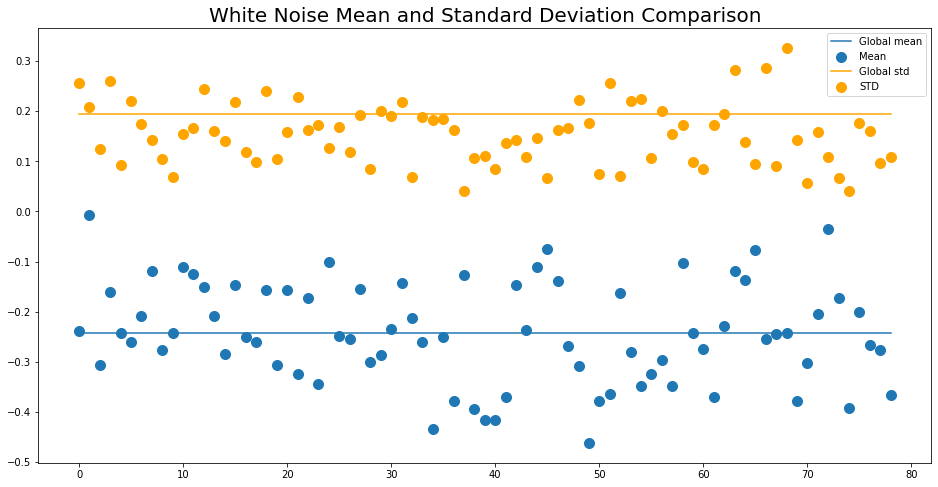

In [14]:
#code snippet from https://towardsdatascience.com/time-series-from-scratch-white-noise-and-random-walk-5c96270514d3
# Split into an arbitraty number of chunks
white_noise_chunks = np.split(sentiment_df["compound"], 79) #5 chunks
means, stds = [], []

# Get the mean and std values for every chunk
for chunk in white_noise_chunks:
    means.append(np.mean(chunk))
    stds.append(np.std(chunk))
    
    
# Plot
fig = plt.figure(figsize=(16,8))
plt.title('White Noise Mean and Standard Deviation Comparison', size=20)
plt.plot(np.arange(len(means)), [sentiment_df["compound"].mean()] * len(means), label='Global mean', lw=1.5)
plt.scatter(x=np.arange(len(means)), y=means, label='Mean', s=100)
plt.plot(np.arange(len(stds)), [sentiment_df["compound"].std()] * len(stds), label='Global std', lw=1.5, color='orange')
plt.scatter(x=np.arange(len(stds)), y=stds, label='STD', color='orange', s=100)
plt.legend();

Here we can see clearly that our mean value is not zero (even if close), standard deviation attests itself around 0.2.

##### 8.2.2.3 Autocorrelation

Autocorrelation is a mathematical representation of the degree of similarity between a given time series and a lagged version of itself over successive time intervals. [[8]](#references_) Autocorrelation plots also include a shaded area that represents confidence intervals. Anything inside the shaded area means that the correlation at that point isn’t statistically significant. Also the X axis represents the lag, and the Y axis is the Pearson’s correlation coefficient at each lag. Please note that autocorrelation at lag 0 will have a value of 1, since the correlation is calculated between two identical time series. In this case autocorrelation answer the question of: how correlated are the news sentiment compound values compared to the previous period.

Generally, when a clear trend exists in a time series, the autocorrelation tends to be high at small lags like 1 or 2. When seasonality exists, the autocorrelation goes up periodically at larger lags.[[9]](#references_)

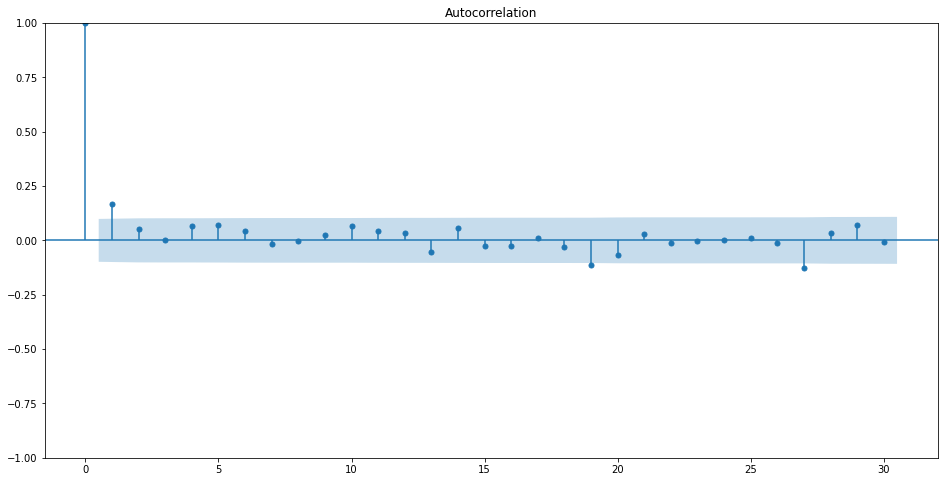

In [15]:

plot_acf(np.array(sentiment_df["compound"]), lags=30); #period of 1 month


Most of the lags are within the confidence interval, while only 3 are slightly out of it. I can conclude that we are not dealing with a random walk for sure and neither with white noise even if we have many of the characteristics of this one.

### 8.3 Decomposition of Time Series

Finally we can have a better picture of the characteristics of the time series by analyzing the trend, seasonability and noise. With these terms we ask ourselves:

* Seasonality: does the data has a clear periodic pattern?
* Trend - does the data presents an important slope
* Noise - are there outliers that are not consistent with our data?

In [16]:
sentiment_df.index = pd.to_datetime(sentiment_df.index)

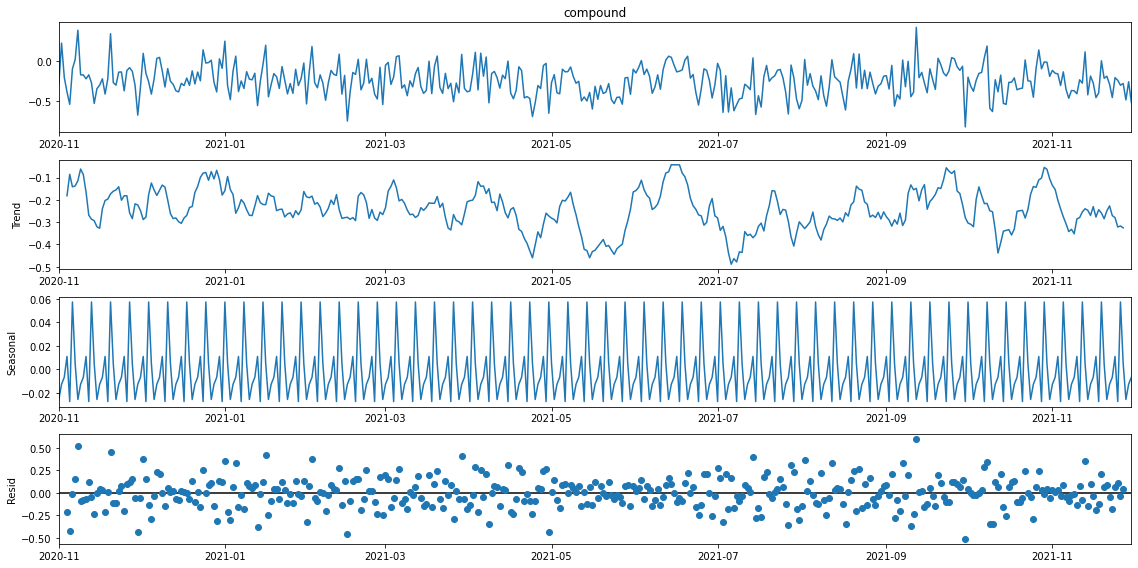

In [17]:

# Additive Decomposition

result_add = seasonal_decompose(sentiment_df["compound"], model='additive') #The term additive means individual components (trend, seasonality, and residual) are added together
result_add.plot();


From this graph we can tell that there's not any strong trend in any direction, seasonability is very noisy and the residual graph doesn't show any strong outliers that can't be attributed to either seasonability and trend.
We conclude that there's not that much that can be inferred using the compound sentiment value solely.

### 8.4 Forecasting Covid?

Now, what about if we add the day frequency of Covid related topics as a new feature and try to understand if there's a trend with the actual virus spread and if there's any correlation between the good and the bad news with covid? Let me try to answer this question:

#### 8.4.1 Covid trend analysis

In [19]:
#creating a new Covid feature
df["coronavirus"] = df["corpuses"].str.contains("coronav|vaccin|quarant|virus|pandem",case=False, regex=True).astype(int)

#creating new dataframe
covid_df = df[["coronavirus", "compound", "negative", "positive"]]

# grouping by different aggregate functions
covid_df = covid_df.groupby(df.index.date).agg({
    "coronavirus": np.sum,
    "compound": np.mean,
    "negative": np.mean,
    "positive": np.mean
})

<AxesSubplot:>

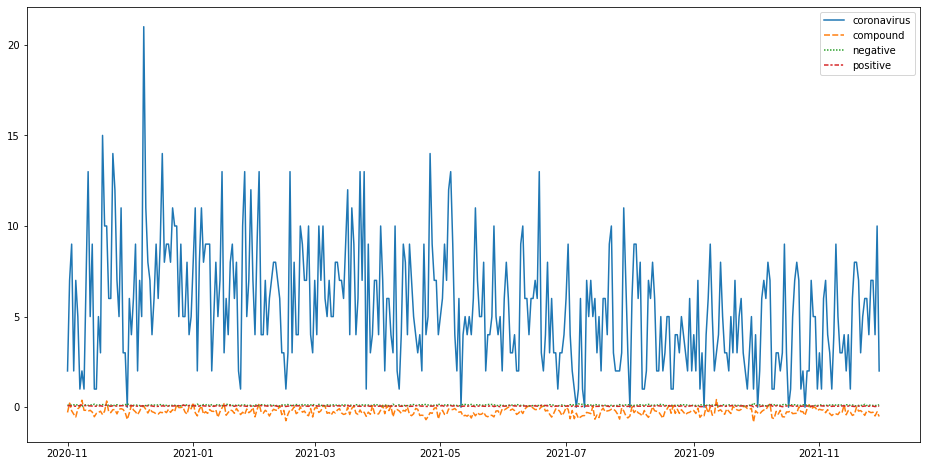

In [21]:
sns.lineplot(data=covid_df)

As we can see, the covid feature is on a different scale compared to the sentiment features, we will take care of this later performing scaling of the features. Now let's focus our attention on the newly created covid feature and analyze it. To smooth out our findings we will use the rolling average feature, where we can describe a rolling average as follow:

>Rolling averages, also known as moving averages, are a type of chart analysis technique used to examine survey data collected over extended periods of time, for example, in political tracking polls. They are typically utilized to smooth out data series. The ultimate purpose of rolling averages is to identify long—term trends. They are calculated by averaging a group of observations of a variable of interest over a specific period of time. Such averaged number becomes representative of that period in a trend line. It is said that these period-based averages "roll," or "move," because when a new observation is gathered over time, the oldest observation of the pool being averaged is dropped out and the most recent observation is included into the average. [[10]](#references_)

Basically, time series data in original format can be quite volatile, especially on smaller aggregation levels. The concept of rolling, or moving averages is a useful technique for smoothing time series data. [[11]](#references_)

Text(0.5, 1.0, 'Coronavirus related news frequency - 30 days rolling mean')

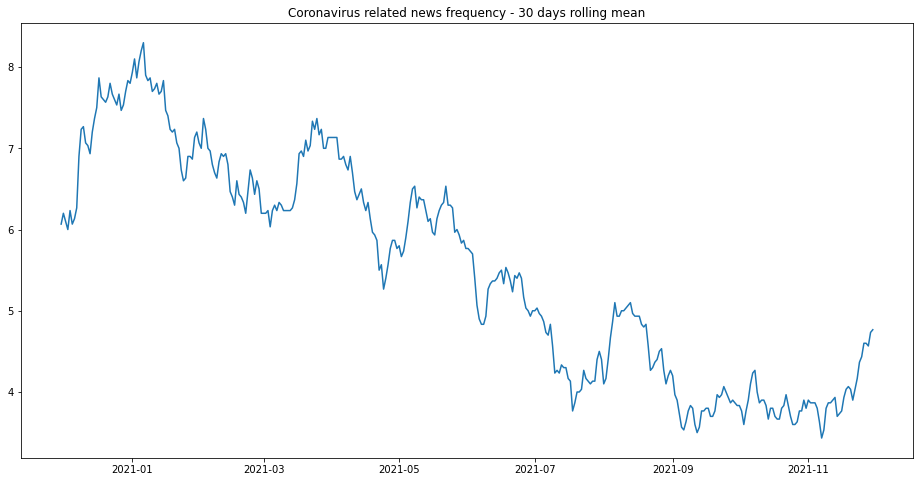

In [22]:
covid_df["coronavirus"].rolling(30).mean().plot() #rolling window of 30 days
plt.title("Coronavirus related news frequency - 30 days rolling mean")

We can see that there's a clear trend. As we said before, the trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. [[12]](#references_)

We will use the statsmodel - deterministic process module: this is specifically indicated to perform time series analysis. In particular we can affirm that a deterministic process is a technical term for a time series that is non-random or completely determined like the const and trend series are. Features derived from the time index will generally be deterministic. [[12]](#references_)

In [23]:
# code snippet from https://www.kaggle.com/ryanholbrook/trend
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=covid_df.index,  # dates from the data
    constant=True,       # dummy feature for the bias
    order=3,             # the time dummy (trend) - we'll use the polinomial order of 3
    drop=True,           # drop terms if necessary to avoid collinearity
)

# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()
X.head()



,const,trend,trend_squared,trend_cubed
2020-11-01,1.0,1.0,1.0,1.0
2020-11-02,1.0,2.0,4.0,8.0
2020-11-03,1.0,3.0,9.0,27.0
2020-11-04,1.0,4.0,16.0,64.0
2020-11-05,1.0,5.0,25.0,125.0


In [24]:
from sklearn.linear_model import LinearRegression

y = covid_df["coronavirus"]  # the target

model = LinearRegression(fit_intercept=False) #LinearRegression behaves badly with duplicated features (link)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

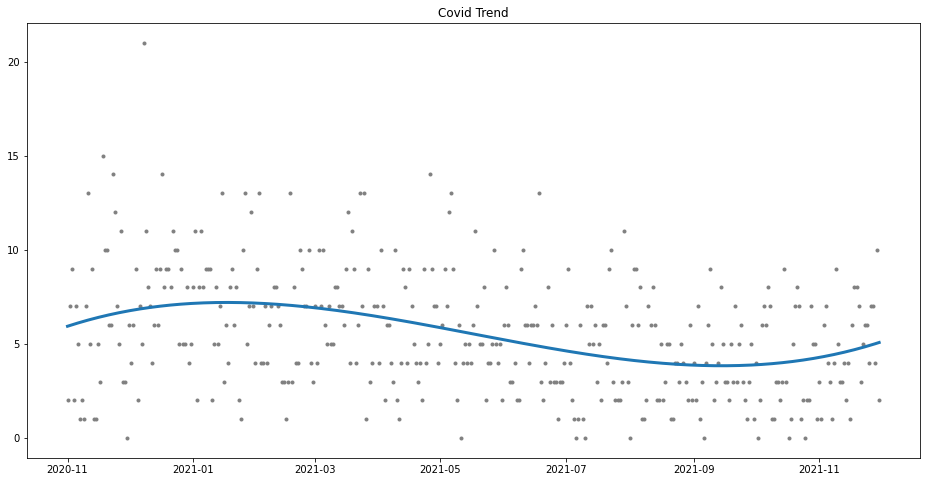

In [25]:
ax = covid_df["coronavirus"].plot(style=".", color="0.5", title="Covid Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

In [26]:
X = dp.out_of_sample(steps=30) #creating the out of sample

base = datetime.datetime(2021,12,1) #creating base time

date_list = [base+datetime.timedelta(days=x) for x in range(30)] # index dates for the forecast

y_fore = pd.Series(model.predict(X), index=date_list) #forecast


In [27]:
#changing the indexes to datetime
covid_df.index = pd.to_datetime(covid_df.index)
y_pred.index= pd.to_datetime(y_pred.index)

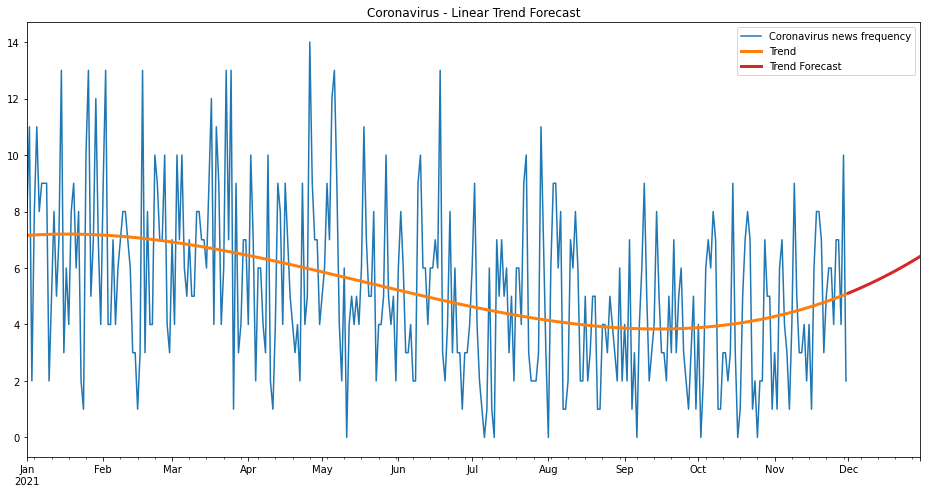

In [28]:
#plot
ax = covid_df["2021-1-1":]["coronavirus"].plot(title="Coronavirus - Linear Trend Forecast", label="Coronavirus news frequency")
ax = y_pred["2021-1-1":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

As we can see, we have a strong upwards trend by the end of November. Considering that this study's data remained unchanged since part 1, and that we are now seeing this "from the future", we can confirm that indeed there has been a strong raise in Covid cases around the world due to the Omicron variant.

#### 8.4.2 Covid news correlation with sentiment features

Let's check now the correlation of the Covid feature with the sentiment scores. We will first scale our features so that we can make them comparable:

In [29]:
scaler = MinMaxScaler() #scaling the features

covid_df_scaled = pd.DataFrame(scaler.fit_transform(covid_df), columns=covid_df.columns, index=covid_df.index)

covid_df_scaled

,coronavirus,compound,negative,positive
2020-11-01,0.095238,0.426644,0.470776,0.383094
2020-11-02,0.333333,0.841879,0.170610,0.489536
2020-11-03,0.428571,0.498824,0.429849,0.370252
2020-11-04,0.095238,0.351188,0.448833,0.346583
2020-11-05,0.333333,0.227181,0.528330,0.254928
...,...,...,...,...
2021-11-26,0.333333,0.418933,0.378615,0.438804
2021-11-27,0.333333,0.436235,0.256470,0.288225
2021-11-28,0.190476,0.271844,0.256897,0.125719
2021-11-29,0.476190,0.453807,0.220030,0.268393


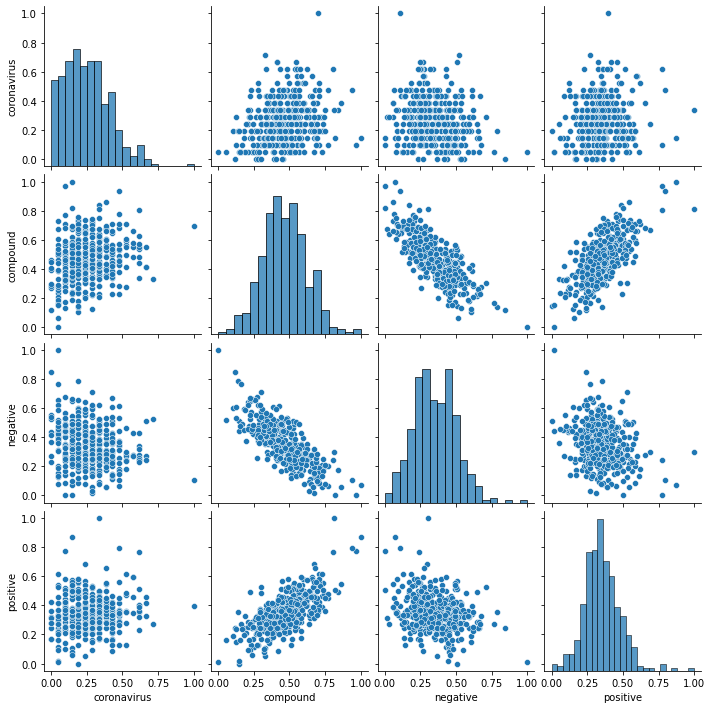

In [30]:
sns.pairplot(data=covid_df_scaled)

As we can see there's no clear correlation between the covid feature and any kind of sentiment score, to have a clearer view let's plot the heatmap with the pearson correlation value:

<AxesSubplot:>

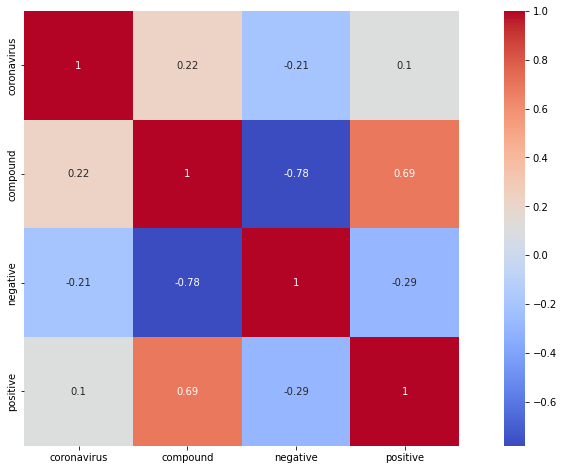

In [31]:
sns.heatmap(covid_df_scaled.corr(method="pearson"), annot=True, cmap="coolwarm", square=True)

We have a slight correlation with the compound and negative value but not comparable with the scale of the (obvious) correlation between the sentiment scores.

### 9 Analyzing Sentiment Scores

Let's have a deeper look now at the sentiment scores. We will analyze them on a daily basis first and then based on the correspondent geographical subsection.

#### 9.1 Daily Good and Bad news

Let's have a look now at the good and bad news and when they had place according to the sentiment analysis. We will try to understand how much the score might correspond to actual bad or good news.

In [32]:
heat = df.pivot_table(index=[df.index.day,df.index.month], values=["compound"], aggfunc="mean").unstack() #creating day vs months table
heat.index.names = ["Day"]
heat.columns.names = ["", "Month"]

Let' plot a map of the days of the month against the months to understand what have been the best and the worst days according to the sentiment score:

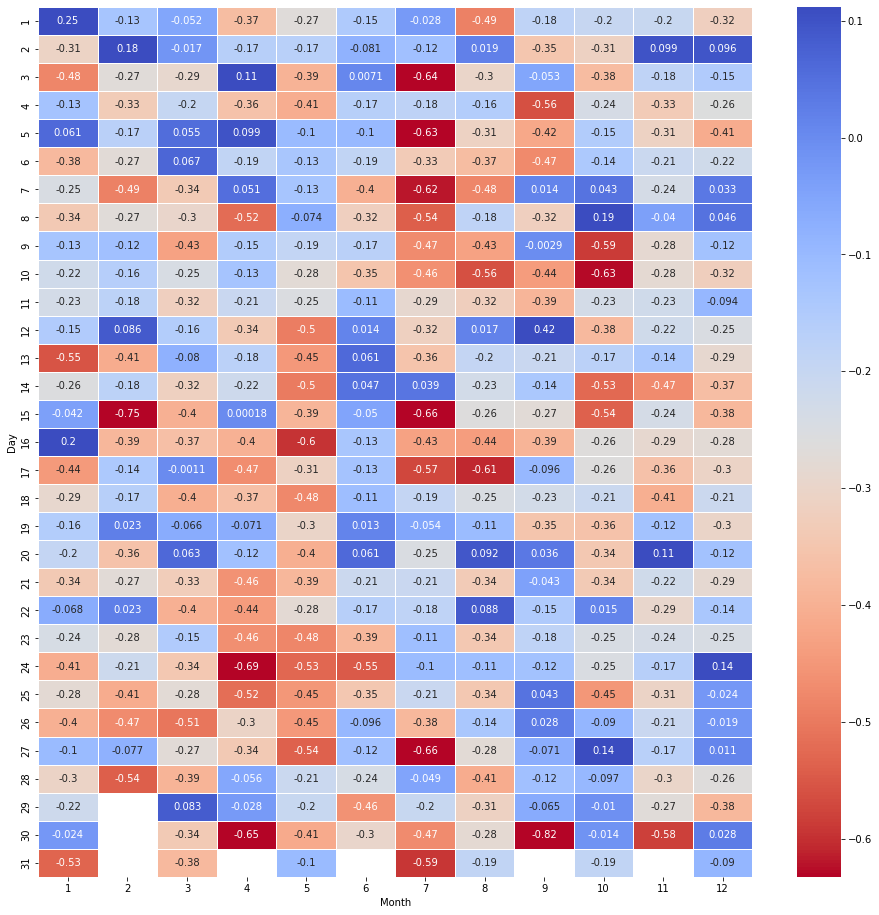

In [33]:
fig, ax = plt.subplots(figsize=(16,16))

ax = sns.heatmap(heat["compound"], cmap="coolwarm_r", annot=True, robust=True, linewidths=.5)

The scores in the heatmap refer to the mean compound sentiment per day. Let's try to place on the time series what the 3 worst and best news were in these days and if their scores actually adhere to the real negativeness or positiveness of the news.

In [34]:
sentiment_df["compound"].sort_values()[:3] #worst days

2021-09-30   -0.819625
2021-02-15   -0.746620
2021-04-24   -0.690700
Name: compound, dtype: float64

In [35]:
print(df.loc["2021-09-30", ["headline","compound"]].sort_values(by="compound")["headline"].values[0])
print(df.loc["2021-02-15", ["headline","compound"]].sort_values(by="compound")["headline"].values[0])
print(df.loc["2021-04-24", ["headline","compound"]].sort_values(by="compound")["headline"].values[0])

Police Officer Sentenced to Life in Prison for Murder of Sarah Everard
Zuma Risks Arrest After Defying South Africa Corruption Inquiry
Terrorism Fears Feed the Rise of France’s Extreme Right


In [36]:
sentiment_df["compound"].sort_values(ascending=False)[:3] #best days

2021-09-12    0.419700
2020-11-08    0.383930
2020-11-20    0.340975
Name: compound, dtype: float64

In [37]:
print(df.loc["2021-09-12", ["headline","compound"]].sort_values(by="compound", ascending=False)["headline"].values[0])
print(df.loc["2021-02-15", ["headline","compound"]].sort_values(by="compound", ascending=False)["headline"].values[0])
print(df.loc["2021-04-24", ["headline","compound"]].sort_values(by="compound", ascending=False)["headline"].values[0])

A New Sports Star Showcases the Diversity of a More Complex Britain
N.Y.C.’s subway system will start running longer into the night next week, officials say.
Debris From Indonesian Submarine Is Found, Ending Hopes of Rescue


In [38]:
peak_days = [
    #worst days
    (datetime.datetime(2021, 9, 30), "Police Officer Sentenced to Life in Prison for Murder of Sarah Everard"),
    (datetime.datetime(2021, 2, 15), "Zuma Risks Arrest After Defying South Africa Corruption Inquiry"),
    (datetime.datetime(2021, 4, 24), "Terrorism Fears Feed the Rise of France’s Extreme Right"),
    #best days
    (datetime.datetime(2021, 9, 12), "A New Sports Star Showcases the Diversity of a More Complex Britain"),
    (datetime.datetime(2020, 11, 8), "N.Y.C.’s subway system will start running longer into the night next week, officials say."),
    (datetime.datetime(2020, 11, 20), "Debris From Indonesian Submarine Is Found, Ending Hopes of Rescue")
]

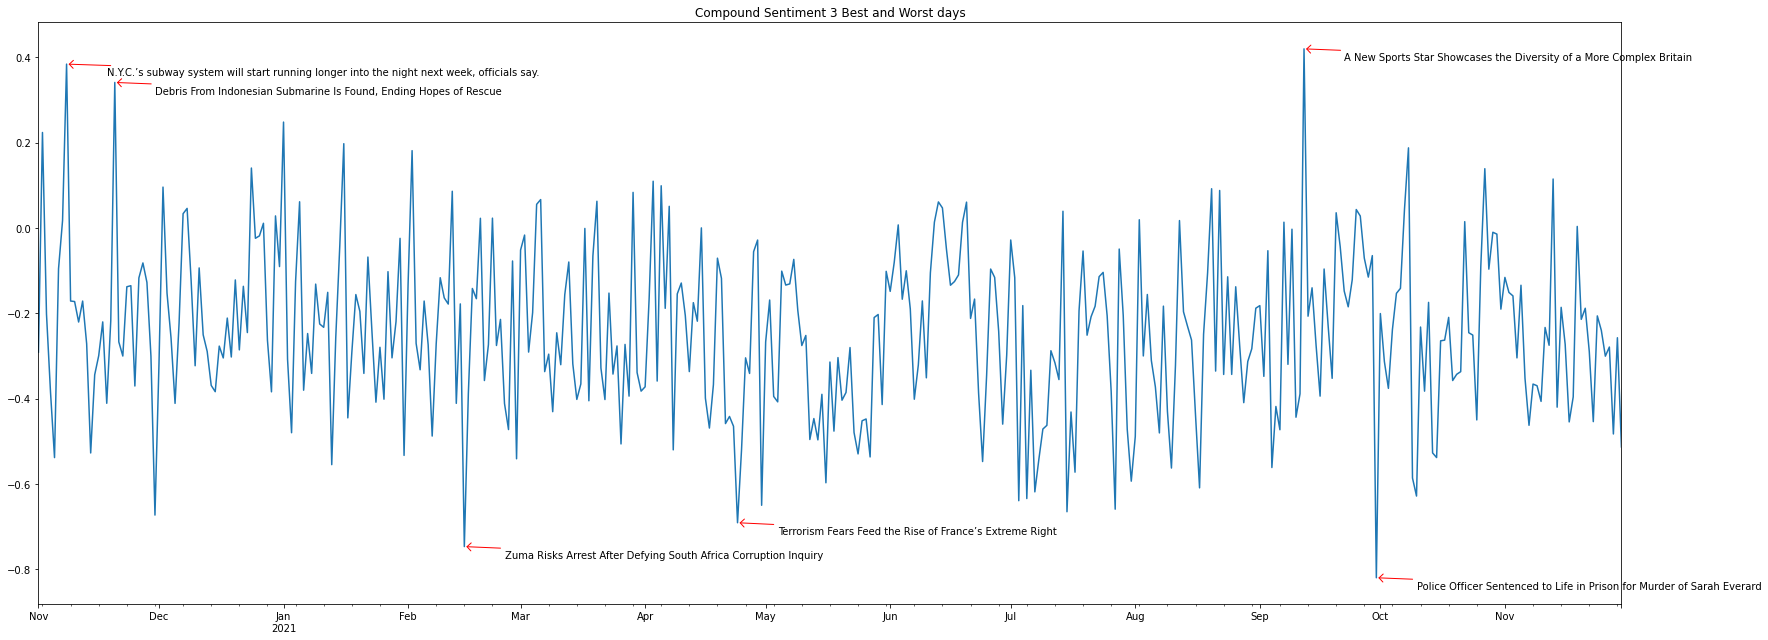

In [39]:
fig, ax = plt.subplots(figsize=(25,9))

comp = sentiment_df["compound"]

comp.plot(ax=ax)

for date, label in peak_days:
    ax.annotate(label, xy=(date, comp.asof(date)),
                xycoords='data',
                xytext=(date+datetime.timedelta(10), comp.asof(date)-0.02),
                arrowprops=dict(facecolor='red',arrowstyle="->,head_width=.4", color="red"),
                horizontalalignment="left", verticalalignment="center"
                )
    
ax.set_title("Compound Sentiment 3 Best and Worst days")

plt.tight_layout()
    

As we can see, bad news can be considered being labeled right, even if the level of negativeness is subjective. As for the good news, we can say that only 2 out of three have been labeled correctly being the finding of the Indonesian submarine a negative news. This is because perhaps "Hopes" and "Rescue" are labeled with a positive score.

#### 9.2 Geographical sentiment analysis

Let's have a look now at the sentiment scores assigned per each news based on the zone of the world and the distribution of the score across these news.

In [40]:
df['ID'] = range(1, len(df) + 1) #creating an ID feature to perform grouping

df["compound_trunc"] = df.compound.round(1) # Dividing the compound scores into 0.1 buckets

#defining the country list
countries = ['Europe',
 'World',
 'Asia Pacific',
 'Middle East',
 'Americas',
 'Africa',
 'Australia',
 'Canada',
 'U.S.',
]

filtered_countries_df = df[df.subsection_name.isin(countries)] #creating the filtered dataframe

In [41]:
#grouped dataframe
res = (filtered_countries_df.groupby(["compound_trunc","subsection_name"])["ID"]
        .count()
        .reset_index()
        .rename(columns={"ID": "count"})
      )

Let's plot first the distribuition of the scores across the news:

In [42]:
hist = alt.Chart(res).mark_bar(width=15).encode(
    alt.X("compound_trunc:Q", axis=alt.Axis(title="")),
    y=alt.Y('count:Q', axis=alt.Axis(title="Count")),
    color=alt.Color('compound_trunc:Q', scale=alt.Scale(scheme='redyellowgreen')), 
    tooltip=['compound_trunc', 'count']
).properties(width = 450)

hist

alt.Chart(...)

As we can see the distribution of the scores is skewed towards the negative scores, having a peak on the 0.9 compound value. This indicates how there is a prevalence of bad news compared to good news (at least for the country news)

Now let's plot the distribuition of the sentiment score per each country. This plot might give us an insight on how each continet or part of the world "performed" in terms of good and bad news.

In [43]:
stacked_bar = alt.Chart(res).mark_bar().encode(
    y = alt.X("subsection_name", axis=alt.Axis(title="Countries")),
    x=alt.Y('count:Q', stack='normalize', axis=alt.Axis(title="", labels=False)),
    color=alt.Color('compound_trunc', scale=alt.Scale(scheme='redyellowgreen')), 
    tooltip=['compound_trunc', 'subsection_name', 'count'],
    order=alt.Order(
      # Sort the segments of the bars by this field
      'compound_trunc',
      sort='ascending')
).properties(height = 850)

stacked_bar

alt.Chart(...)

Text(0.5, 1.0, 'News Count per Subsection')

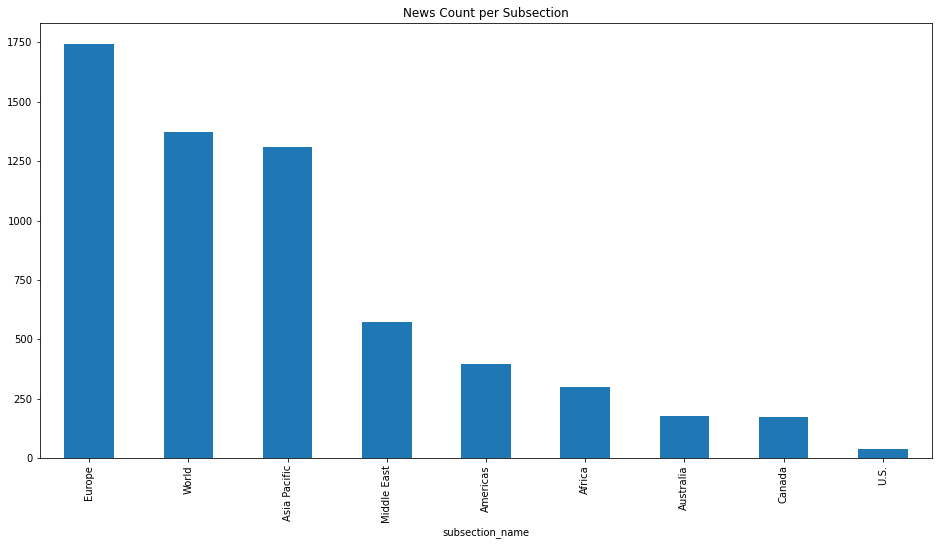

In [44]:
filtered_countries_df.groupby("subsection_name")["ID"].count().sort_values(ascending=False).plot(kind="bar")
plt.title("News Count per Subsection")

As we can see, the continent that is performing the worst according to the sentiment scores is Africa while the one that is performing the best is U.S. These results must take into account as well the amount of news per country. As we can see indeed, U.S. has the least amount of news whilst Africa is in the lower part of the plot. This might give an unbalanced result. Also, we can see how the sentiment score for the world news is more normally distributed being the bad and good news almost 50%.

Let's plot now the word frequency per each country to have a better understanding of what the main topics have been:

In [45]:
df_topics = filtered_countries_df.groupby("subsection_name")["corpuses"].sum().to_frame()


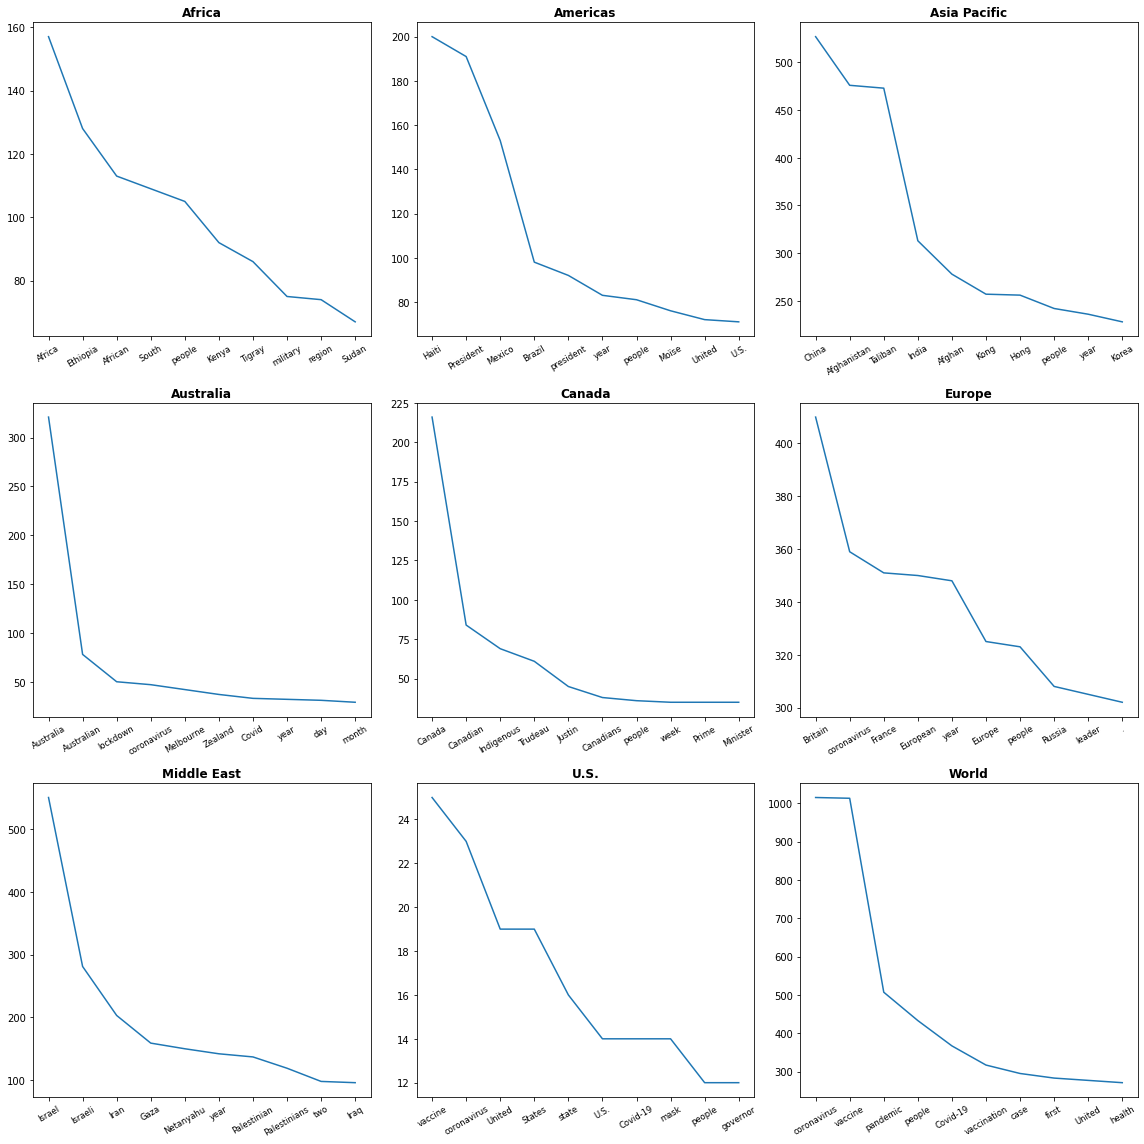

In [46]:
fig, ax = plt.subplots(nrows=3,ncols=3, figsize=(16,16))
ax=ax.ravel() #smoothing the list

for topics, a in enumerate(ax):
    f_dist = FreqDist(nltk.tokenize.word_tokenize(text_cleaner(df_topics.iloc[topics][0])))
    a.plot(*zip(*f_dist.most_common(10))) #tuple upacking for plotting
    a.set_xticklabels(list(zip(*f_dist.most_common(10)))[0], rotation=30, fontsize="small")
    a.set_title(df_topics.index[topics], weight="bold")
    plt.tight_layout()

As we would expect the most used words are country-related. Not surprisingly, the most used words in the World subsection are Covid related, while for example in Europe Great Britain has been the main word. This is due, as we saw, to the fact that the U.K. was the first European country to deploy a vaccine to the public.

<a id="references_"></a>
# Refrences

[1] ELVIS, , Examining Gender and Race Bias in Sentiment Analysis Systems. Available: https://medium.com/dair-ai/examining-gender-and-race-bias-in-sentiment-analysis-systems-b04b269a653 [10/02/, 2021].

[2] DIMITRIS EFFROSYNIDIS, , Time Series Analysis with Theory, Plots, and Code Part 1. Available: https://towardsdatascience.com/time-series-analysis-with-theory-plots-and-code-part-1-dd3ea417d8c4 [10/02/, 2021].

[3] SHAY PALACHY, , Stationarity in time series analysis. Available: https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322 [10/02/, 2021].

[4] VINOD CHEDALAVADA, , Analysis of Time Series Data . Available: https://medium.com/analytics-vidhya/analysis-of-time-series-data-dad4afa56358 [10/02/, 2021].

[5] PANWAR ABHASH ANIL, , Introduction to Time Series Analysis and key concepts. Available: https://medium.com/analytics-vidhya/introduction-to-time-series-analysis-and-key-concepts-dbf6c394984f [10/02/, 2021].

[6] BEX, T., , How to Detect Random Walk and White Noise in Time Series Forecasting. Available: https://towardsdatascience.com/how-to-detect-random-walk-and-white-noise-in-time-series-forecasting-bdb5bbd4ef81 [10/02/, 2021].

[7] SELVA PRABHAKARAN, , KPSS Test for Stationarity. Available: https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/ [10/02/, 2021].

[8] TIM SMITH, , Autocorrelation. Available: https://www.investopedia.com/terms/a/autocorrelation.asp [10/02/, 2021].

[9] BEX, T., , Advanced Time Series Analysis in Python: Seasonality and Trend Analysis (Decomposition), Autocorrelation. Available: https://towardsdatascience.com/advanced-time-series-analysis-in-python-decomposition-autocorrelation-115aa64f475e [10/02/, 2021].

[10] PAUL J. LAVRAKAS, , Rolling Avarages. Available: https://methods.sagepub.com/reference/encyclopedia-of-survey-research-methods/n497.xml.

[11] DARIO RADEČIĆ, , Time Series From Scratch — Introduction to Time Series with Pandas. Available: https://towardsdatascience.com/time-series-from-scratch-introduction-to-time-series-with-pandas-347ac9c6b451.

[12] RYAN HOLBROOK and ALEXIS COOK, , Trend . Available: https://www.kaggle.com/ryanholbrook/trend.